In [1]:
%load_ext autoreload
%autoreload 2

# Simplest possible multi-layer perceptron

## The plan

We will explore whether the general architecture and settings of the MLP from notebook 02 provide a malleable and complex enough model that it can learn the intended target. To do this, we will explore a set of increasingly more challenging mathematical functions to fit:

#### Function 1:

$f(x) = a x $

#### Function 2:

$f(x) = \Sigma_{i = 0}^{n} a_i x $

#### Function 3:

$f(x) = \Sigma_{i = 0}^{n} a_i x + b_i x^2 $

#### Function 4:

$f(x) = \Sigma_{i = 0}^{n} a_i (x - c_i)^2 + b_i x^2 $






## Imports

In [2]:
from sklearn.preprocessing import MinMaxScaler
from functools import partial
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns
import haiku as hk
import optax
import jax
from typing import List
from jaxtyping import Array, Float, Int
from sklearn.utils import shuffle

jax.config.update('jax_platform_name', 'cpu')


np.random.seed(0)

jax.devices()


I0000 00:00:1697492449.620340   13306 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

## Target functions

In [3]:
def f1(x, a):
    return a * x

def f2(x, a):
    return np.sum(a * x, axis=0)

def f3(x, a, b):
    return np.sum(a * x + b * np.power(x, 2), axis=0)

def f4(x, a, b, c):
    return np.sum(a * (x - np.power(c, 2)) - b * np.power(x, 3), axis=0)

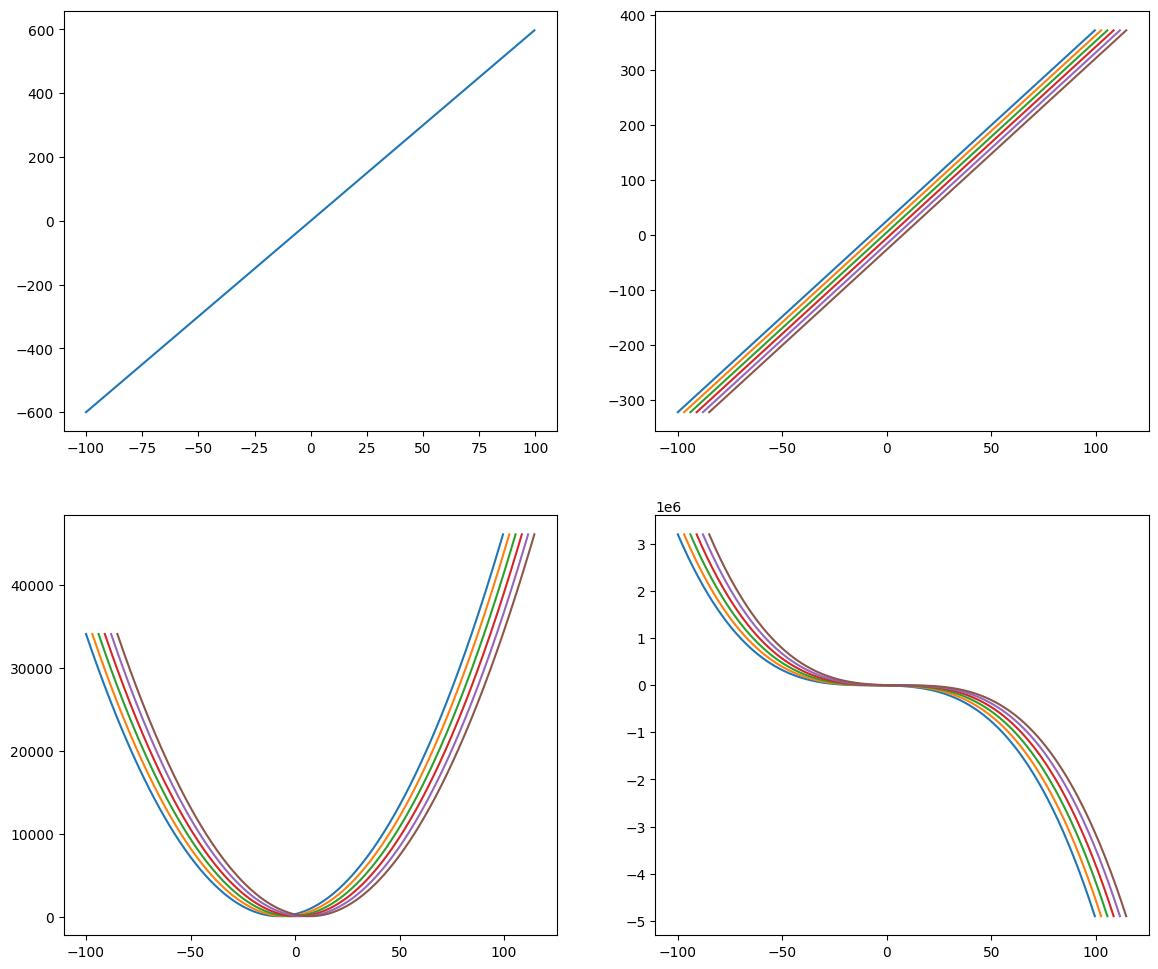

In [4]:
plt.figure(figsize = (2*7, 2*6))

n_unique = 6

x1 = np.arange(-100, 100, 0.5)
x2 = sum(np.meshgrid(x1, np.arange(0, n_unique * 3, 3)))
a1 = 6
a2 = np.random.rand(n_unique)[:, None]
b = np.random.rand(n_unique)[:, None]
c = np.random.rand(n_unique)[:, None]

ax = plt.subplot(2,2,1)
plt.plot(x1, f1(x1, a1))
ax = plt.subplot(2,2,2)
plt.plot(x2.T, f2(x2, a2))
ax = plt.subplot(2,2,3)
plt.plot(x2.T, f3(x2, a2, b))
ax = plt.subplot(2,2,4)
plt.plot(x2.T, f4(x2, a2, b, c))

## Learning setup

### Model

In [5]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/haiku-cnn

class FCN(hk.Module):

    def __init__(self, layer_sizes: List[int], n_head: int, use_categorical: bool):
        super().__init__(name="FCN")
        self.layers = self.create_layers(layer_sizes, n_head, use_categorical)
        
        
    def create_layers(self, layer_sizes: List[int], n_head: int, use_categorical: bool):
        sizes = layer_sizes + [n_head]
        l = []
        for i, s in enumerate(sizes):
            if l:
                l.append(jax.nn.relu)
                if np.mod(i, 2) == 0:
                    l.append(jax.nn.sigmoid)
            # if sj == n_head:
            #     l.append(eqx.nn.Dropout(p=0.4))
            
            # He initialisation
            l.append(
                hk.Linear(s, w_init=hk.initializers.VarianceScaling(scale=2.0))
            )
            
        if use_categorical:
            l.append(jax.nn.log_softmax)
        return l
        

    def __call__(self, x: Float[Array, " num_interactions"], inference: bool = False, seed: int = 0) -> Float[Array, " n_head"]:
        for i, layer in enumerate(self.layers):
            kwargs = {} if not type(layer) == eqx.nn.Dropout else {
                'inference': inference, 'key': jax.random.PRNGKey(seed)}

            x = layer(x, **kwargs)
            
            # wandb.log({f'emb_{i}_{type(layer)}': x})
        return x
    
    
def FCN_fn(x, **kwargs):
    model = FCN(**kwargs)
    return model(x)

### Loss

In [6]:
def loss_fn(
    params, rng,
    model: FCN, x: Float[Array, " batch n_interactions"], y: Int[Array, " batch"], 
    l2_reg_alpha: Float,
    loss_type: str = 'categorical'
) -> Float[Array, ""]:
    
    pred_y = model.apply(params, rng, x)
    if loss_type == 'categorical':
        loss = cross_entropy(y, pred_y, num_classes=pred_y.shape[-1]) / len(x)
    else:
        loss = mse_loss(y, pred_y.flatten())

    # Add L2 loss
    # loss += sum(
    #     l2_loss(w, alpha=l2_reg_alpha) 
    #     for w in jax.tree_util.tree_leaves(params)
    # )
    return loss


def l2_loss(weights, alpha):
    return alpha * (weights ** 2).mean()


def cross_entropy(y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"], num_classes: int):
    one_hot_actual = jax.nn.one_hot(y, num_classes=num_classes)
    return optax.softmax_cross_entropy(pred_y, one_hot_actual).sum()


def mse_loss(y, pred_y):
    return jnp.mean(jnp.square(pred_y - y))


def update_params(optimiser, params, grads):
    updates, optimizer_state = optimiser.update(grads, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params


@eqx.filter_jit
def compute_accuracy(
    params, rng, model: FCN, x: Float[Array, "batch num_interactions"], y: Int[Array, " batch n_head"]
) -> Float[Array, ""]:
    pred_y = model.apply(params, rng, x)
    pred_y = jnp.argmax(pred_y, axis=1)
    return jnp.mean(y == pred_y)




### Hyperparameters

In [7]:
BATCH_SIZE = 128
N_BATCHES = 1000
TOTAL_DS = BATCH_SIZE * N_BATCHES
TRAIN_SPLIT = int(0.8 * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 5e-3
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 100
PRINT_EVERY = EPOCHS // 30
SEED = 1
INPUT_SPECIES = 'RNA_1'

# MLP Architecture
LAYER_SIZES = [64, 64, 64]
USE_CATEGORICAL = True

loss_fn = partial(loss_fn, loss_type = 'categorical' if USE_CATEGORICAL else 'mse')

n_samples = 3

rng = jax.random.PRNGKey(SEED)


## Create Data 

In [8]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
numerical_resolution = 2


In [9]:
x = np.random.rand(TOTAL_DS)[:, None]

y = f1(x, a=3)

if USE_CATEGORICAL:
    y_map = {k: numerical_resolution for k in np.arange(int(f'{y[y != 0].min():.0e}'.split('e')[1])-1, np.max([int(f'{y.max():.0e}'.split('e')[1])+1, 0 +1]))}
    y_map[-6] = 1
    y_map[-5] = 1
    y_map[-4] = 4
    y_map[-3] = 2
    y_map[-1] = 3
    y = jax.tree_util.tree_map(partial(vectorized_convert_to_scientific_exponent, numerical_resolution=y_map), y)
    y = np.interp(y, sorted(np.unique(y)), np.arange(len(sorted(np.unique(y))))).astype(int)
else:
    zero_log_replacement = -10.0
    y = np.where(y != 0, np.log10(y), zero_log_replacement)
    
x, y = shuffle(x, y, random_state=SEED)

N_HEAD = len(np.unique(y)) if USE_CATEGORICAL else 1


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [10]:
xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
x = xscaler.fit_transform(x)

x_train, y_train = x[:TRAIN_SPLIT], y[:TRAIN_SPLIT]
x_val, y_val = x[-TEST_SPLIT:], y[-TEST_SPLIT:]

## Initialise

In [11]:
model = hk.transform(partial(FCN_fn, layer_sizes=LAYER_SIZES, n_head=N_HEAD, use_categorical=USE_CATEGORICAL))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Optimiser

In [12]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE

warmup_fn = optax.linear_schedule(
    init_value=0., end_value=LEARNING_RATE,
    transition_steps=WARMUP_EPOCHS * N_BATCHES)
cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
cosine_fn = optax.cosine_decay_schedule(
    init_value=LEARNING_RATE,
    decay_steps=cosine_epochs * N_BATCHES)
schedule_fn = optax.join_schedules(
    schedules=[warmup_fn, cosine_fn],
    boundaries=[WARMUP_EPOCHS * N_BATCHES])


optimiser = optax.sgd(learning_rate=learning_rate_scheduler)
# optimiser = optax.sgd(learning_rate=schedule_fn)
optimiser_state = optimiser.init(x)

## Train

In [13]:
def train_step(params, rng, model, x, y, optimiser, optimiser_state, l2_reg_alpha):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, loss, grads


def eval_step(params, rng, model: FCN, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def train(params, rng, model, x_train, y_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs, batch_size: int,
          save_every: int = 50):
    saves = {}
    n_batches = (x_train.shape[0]//batch_size)+1
    for e in range(epochs):

        for batch in range(n_batches):
            start = int(batch*batch_size)
            end = int((batch+1)*batch_size) if batch != n_batches - 1 else None

            # Single batch of data
            x_batch, y_batch = x_train[start:end], y_train[start:end]

            if len(x_batch) and len(y_batch):
                params, train_loss, grads = train_step(
                    params, rng, model, x_batch, y_batch, optimiser, optimiser_state, l2_reg_alpha)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')
    return params, saves

In [14]:
params, saves = train(params, rng, model, x_train, y_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                      save_every=PRINT_EVERY) #int(STEPS // 15))

Epoch 0 / 100 -		 Train loss: 190.3663330078125	Val loss: 38324.3359375	Val accuracy: 0.5144921541213989
Epoch 3 / 100 -		 Train loss: 190.31741333007812	Val loss: 38260.55078125	Val accuracy: 0.5144921541213989
Epoch 6 / 100 -		 Train loss: 190.31246948242188	Val loss: 38249.44140625	Val accuracy: 0.5144921541213989
Epoch 9 / 100 -		 Train loss: 190.2867889404297	Val loss: 38246.57421875	Val accuracy: 0.5144921541213989
Epoch 12 / 100 -		 Train loss: 190.2813262939453	Val loss: 38244.44921875	Val accuracy: 0.5144921541213989
Epoch 15 / 100 -		 Train loss: 190.29296875	Val loss: 38242.25	Val accuracy: 0.5144921541213989
Epoch 18 / 100 -		 Train loss: 190.3085479736328	Val loss: 38240.4765625	Val accuracy: 0.5144921541213989
Epoch 21 / 100 -		 Train loss: 190.32395935058594	Val loss: 38238.7890625	Val accuracy: 0.5144921541213989
Epoch 24 / 100 -		 Train loss: 190.33584594726562	Val loss: 38237.48828125	Val accuracy: 0.5144921541213989
Epoch 27 / 100 -		 Train loss: 191.05911254882812	V

## Visualise

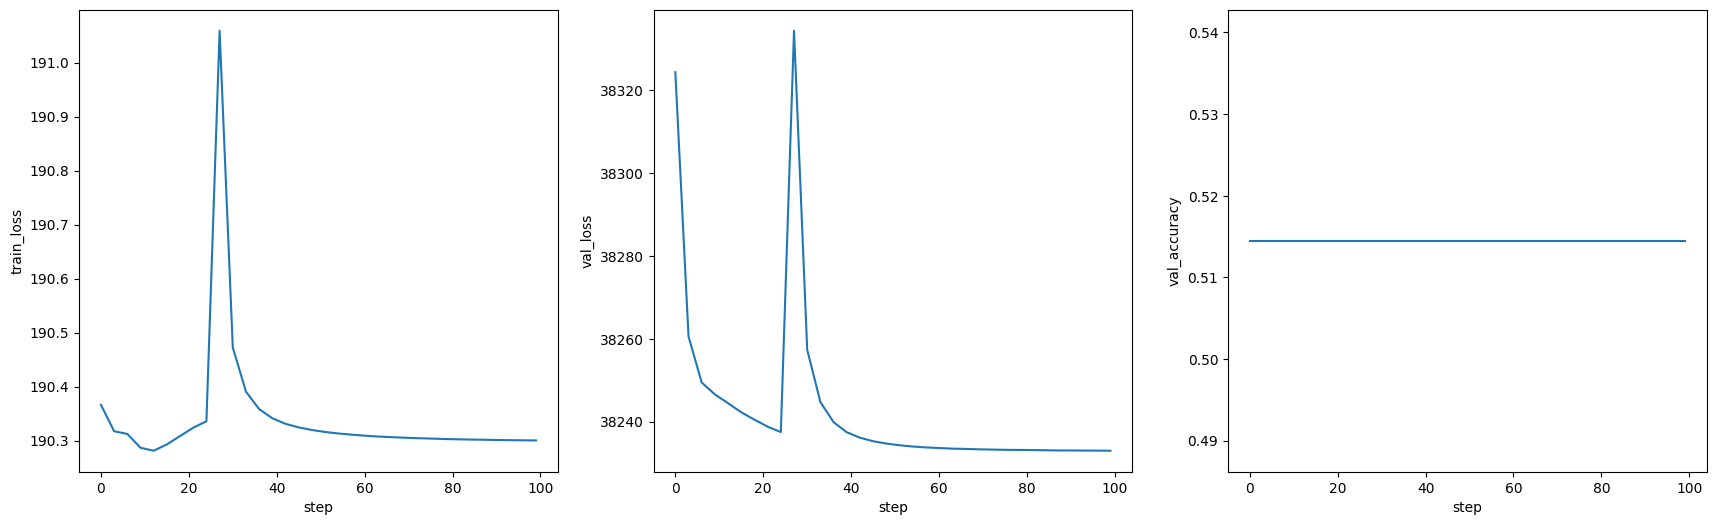

In [15]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1,3,1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1,3,3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.savefig('training_summary.png')


In [16]:
model.apply(params, rng, x_val)

Array([[-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ],
       [-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ],
       [-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ],
       ...,
       [-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ],
       [-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ],
       [-10.603986  , -10.050121  , -10.227545  , ...,  -2.784748  ,
         -0.63934815,  -1.8497921 ]], dtype=float32)

In [17]:
predicted = model.apply(params, rng, x_val.T)
if USE_CATEGORICAL:
    predicted = jnp.argmax(predicted, axis=1)

sns.scatterplot(x=y_val, y=predicted.flatten(), alpha=0.1)
plt.title('Predicted vs. actual labels')
plt.ylabel('Predicted')
plt.xlabel('Actual')


ValueError: 'FCN/~create_layers/linear/w' with retrieved shape (1, 64) does not match shape=[25600, 64] dtype=dtype('float64')